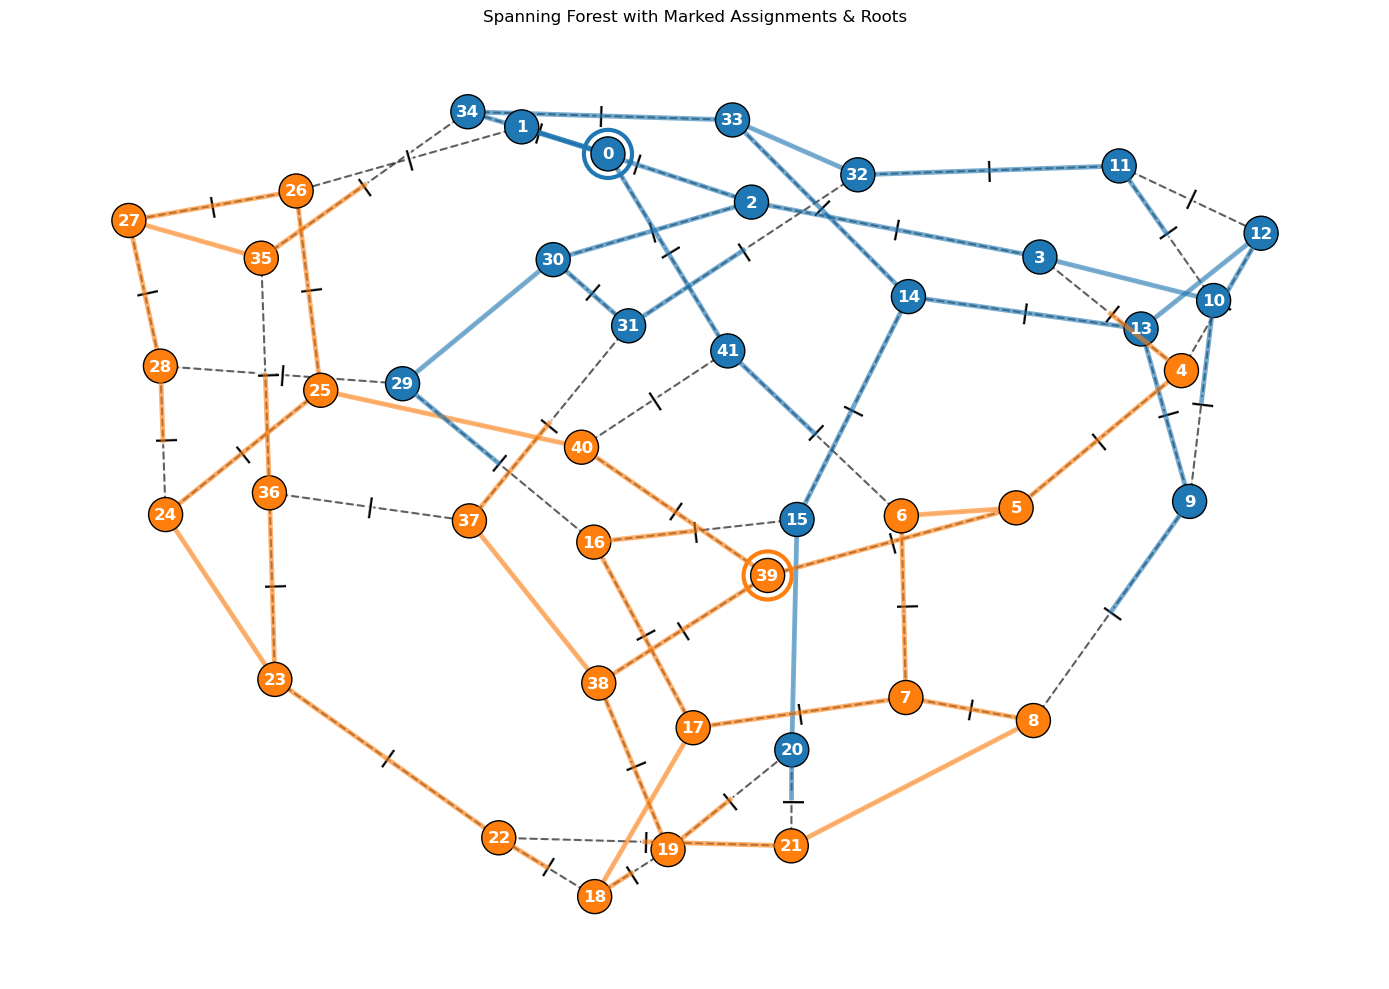

In [4]:
import stim

from spidercat.draw import draw_spanning_forest_solution
from spidercat.spanning_tree import find_min_height_roots
from spidercat.utils import load_solution_triplet, ed

grf, forest, M, matchings = load_solution_triplet(50, 4, 2)
roots = find_min_height_roots(forest)

draw_spanning_forest_solution(grf, forest, M, matchings, roots)

M: {(0, 9): 1, (0, 1): 1, (0, 6): 1, (1, 2): 1, (1, 5): 1, (2, 3): 1, (2, 7): 1, (3, 4): 1, (3, 8): 1, (4, 5): 1, (4, 9): 1, (5, 6): 1, (6, 7): 1, (7, 8): 1, (8, 9): 1}
matchings: {2: [(2, 3)], 4: [(4, 5)], 5: [(1, 5)], 7: [(2, 7)], 9: [(4, 9)], 6: [(6, 7)]}
=== Starting Clean Extraction ===
  Estimated Data Qubits: 15
  Flags start at: 15
Init Root 9 (Tree 0) -> Q0
    Match Allocation: Node 9 (Internal Node) spawns Q1 for (4, 9)
    Link (4, 9) (1st visit): Created Flag 15, CNOT 1->15
  Node 9 -> Branch 8 (New Q2)
    Internal Mark (8, 9): Added Q3
  Node 8 -> Branch 7 (New Q4)
    Internal Mark (7, 8): Added Q5
    Match Allocation: Node 7 absorbs (2, 7)
    Link (6, 7) (1st visit): Created Flag 16, CNOT 4->16
    Link (2, 7) (1st visit): Created Flag 17, CNOT 4->17
  Node 8 -> Primary 3 (Inherits Q2)
    Internal Mark (3, 8): Added Q6
    Link (2, 3) (1st visit): Created Flag 18, CNOT 2->18
  Node 3 -> Primary 4 (Inherits Q2)
    Internal Mark (3, 4): Added Q7
    Match Allocation:

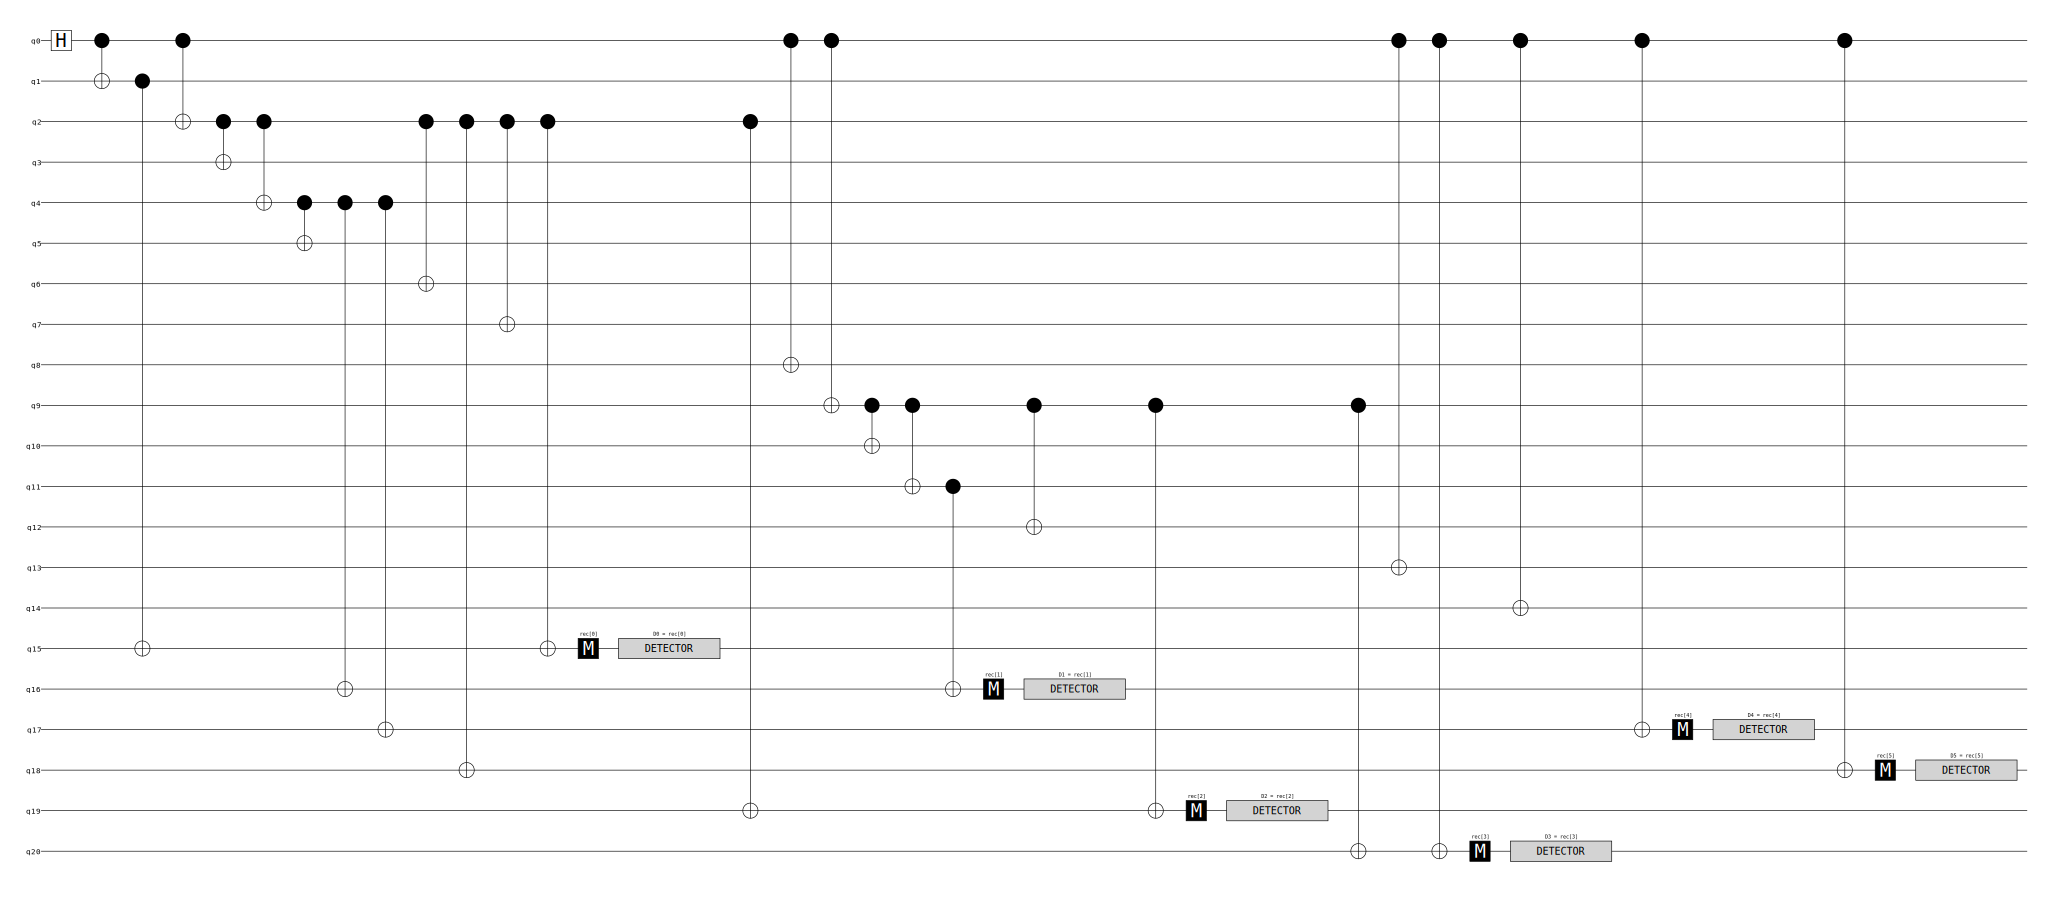

In [6]:
from spidercat.circuit_extraction import extract_circuit_rooted

M = {ed(*k): v for k, v in M.items()}
print("M:", M)
print("matchings:", matchings)
circ = extract_circuit_rooted(grf, forest, roots, M, matchings, verbose=True)
circ.diagram('timeline-svg')

In [3]:
from spidercat.circuit_extraction import make_stim_circ_noisy

# noisy_circ = make_stim_circ_noisy(circ, p_init=0.01, p_meas=0.01)

circ.append("M", range(sum(M.values())))
sampler = circ.compile_sampler()
samples = sampler.sample(100)
print(samples[:5])
converter = circ.compile_m2d_converter()
detectors = converter.convert(measurements=samples, append_observables=False)
error_detected = np.any(detectors, axis=1)
print(detectors[:5])
print(error_detected[:5])

[[ True  True  True  True False False False False False False]
 [False False False False  True  True  True  True  True  True]
 [False False False False  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [False False False False  True  True  True  True  True  True]]
[[False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]]
[False False False False False]


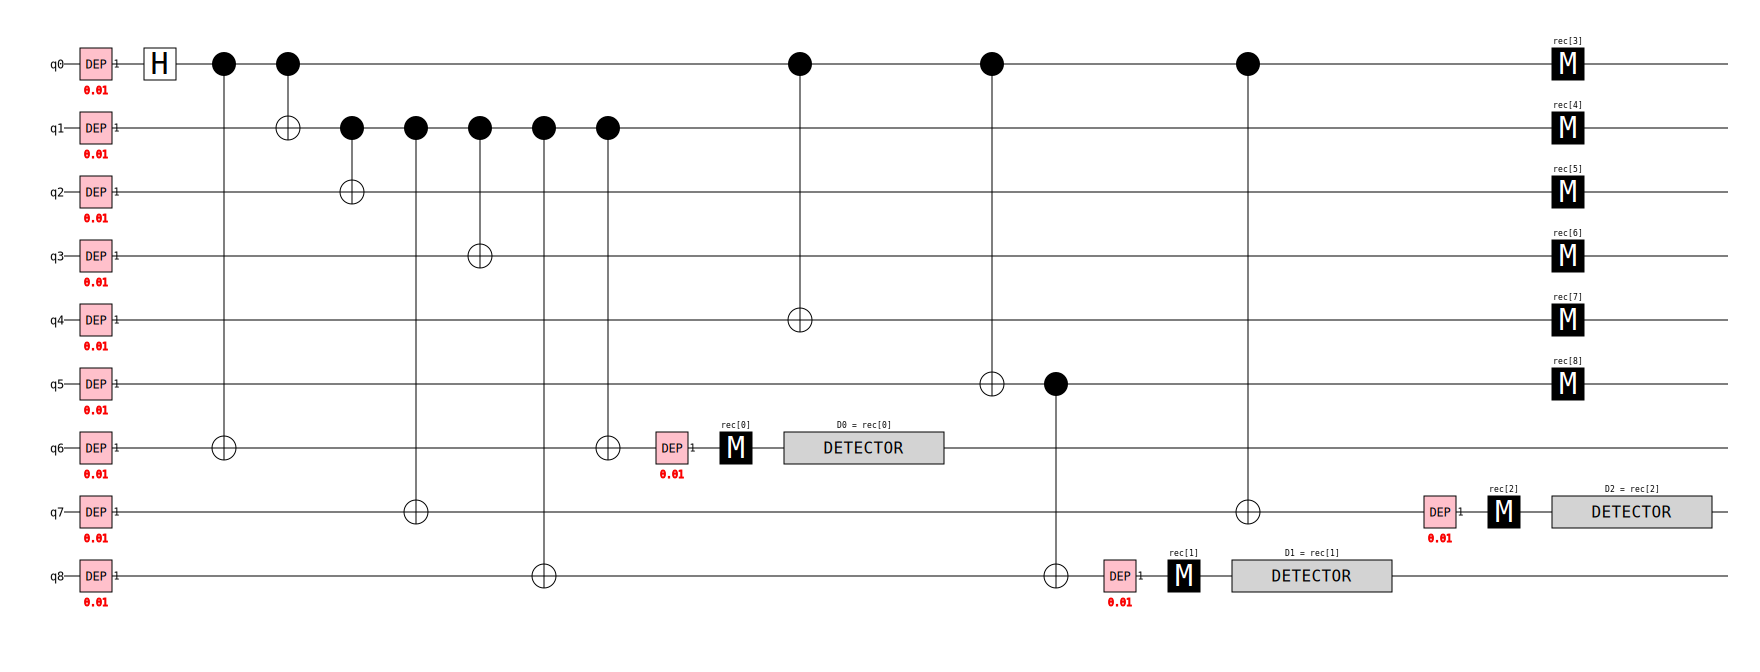

In [4]:
noisy_circ.diagram('timeline-svg')

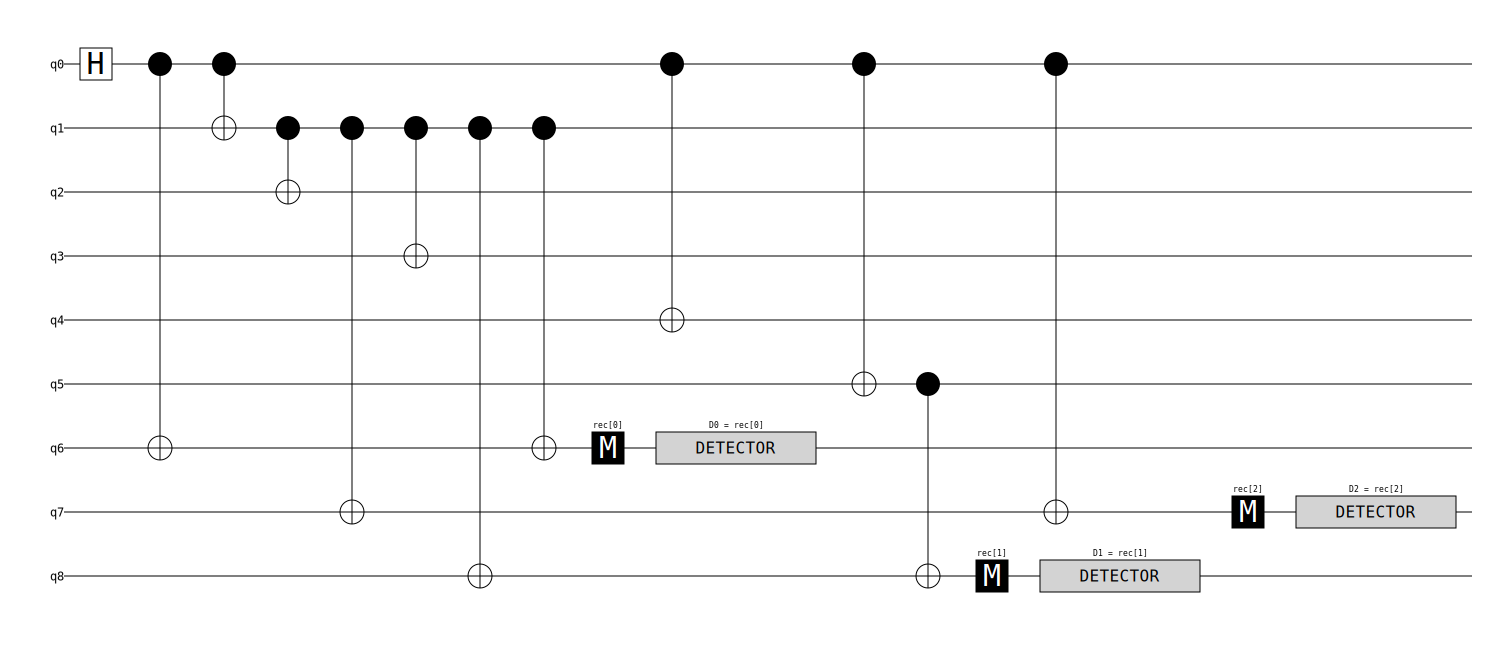

In [5]:
circ.diagram('timeline-svg')

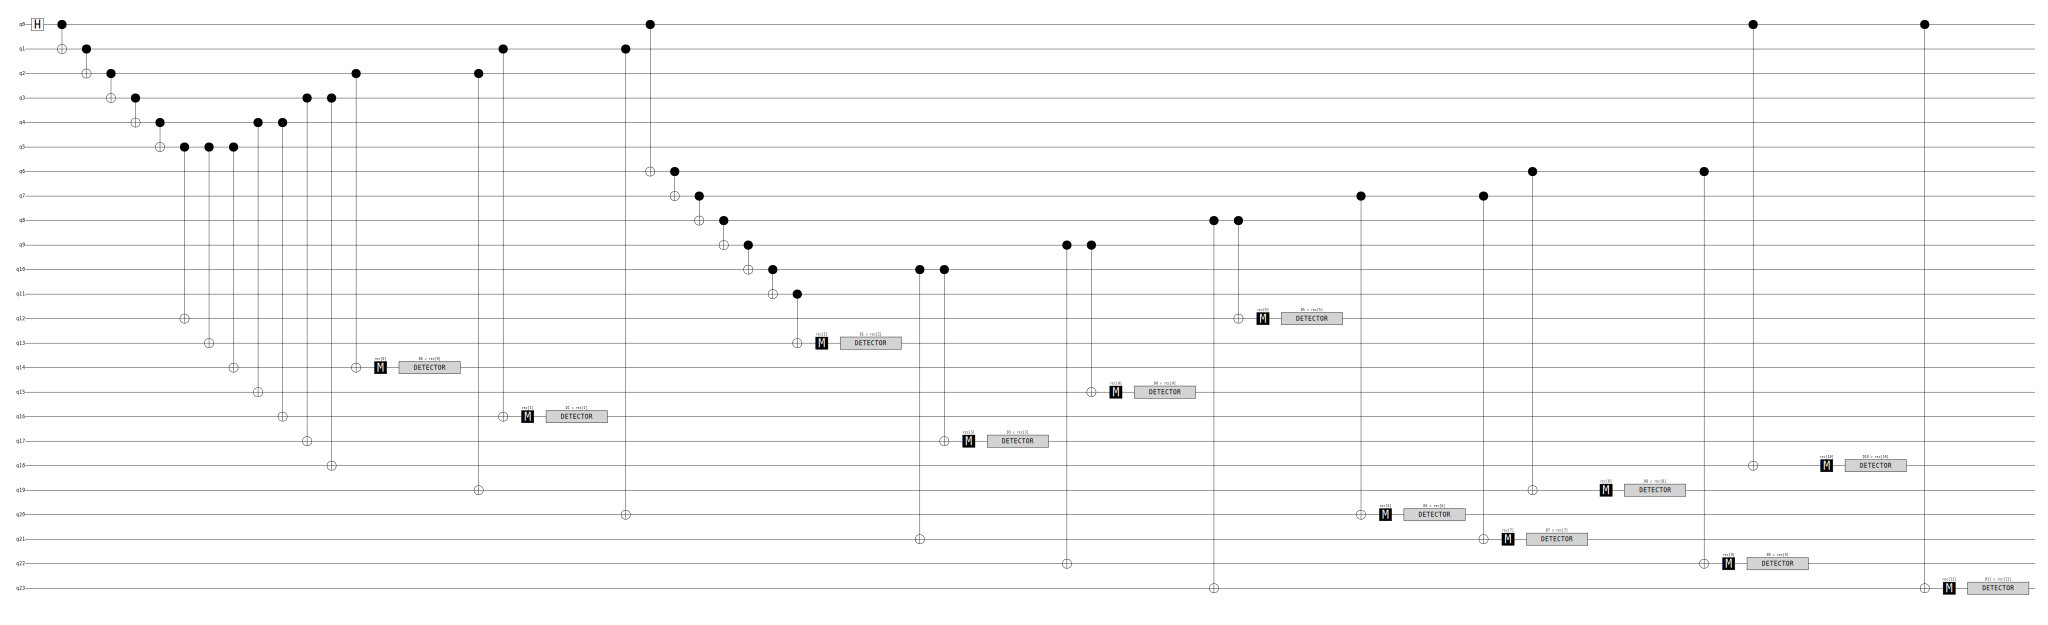

In [1]:
import stim

circ = stim.Circuit("""
H 0
CX 0 1 1 2 2 3 3 4 4 5 5 12 5 13 5 14 4 15 4 16 3 17 3 18 2 14
M 14
DETECTOR rec[-1]
CX 2 19 1 16
M 16
DETECTOR rec[-1]
CX 1 20 0 6 6 7 7 8 8 9 9 10 10 11 11 13
M 13
DETECTOR rec[-1]
CX 10 21 10 17
M 17
DETECTOR rec[-1]
CX 9 22 9 15
M 15
DETECTOR rec[-1]
CX 8 23 8 12
M 12
DETECTOR rec[-1]
CX 7 20
M 20
DETECTOR rec[-1]
CX 7 21
M 21
DETECTOR rec[-1]
CX 6 19
M 19
DETECTOR rec[-1]
CX 6 22
M 22
DETECTOR rec[-1]
CX 0 18
M 18
DETECTOR rec[-1]
CX 0 23
M 23
DETECTOR rec[-1]
""")
circ.diagram('timeline-svg')

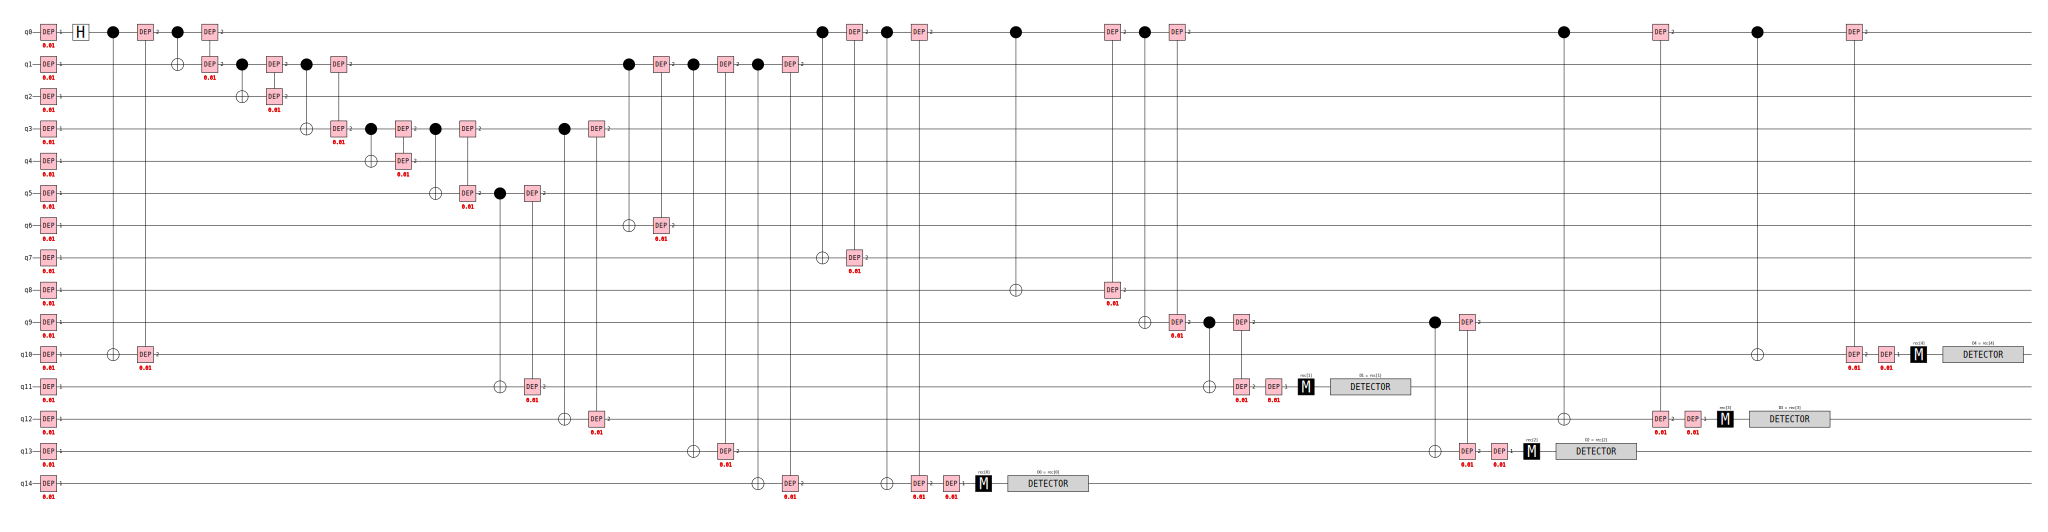

In [9]:
noisy_circ = make_stim_circ_noisy(circ, p_init=0.01, p_meas=0.01, p_2=0.01)
noisy_circ.diagram('timeline-svg')